# XGBoost (eXtreme Gradient Boost)
---

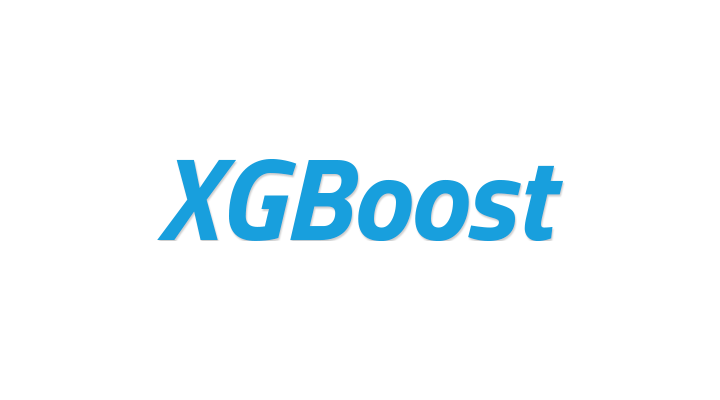

XGBoost는 트리 기반의 앙상블 학습 모델로 GBM을 기반으로 새롭게 만들어진 세계에서 가장 각광받는 그래디언트 부스팅 기반 ML 패키지 입니다.

XGBoost는 분류와 회귀 문제에 있어서 일반적으로 다른 ML 알고리즘보다 뛰어난 예측 성능을 보여 실제 캐글에서 수많은 상위권 데이터 과학자들이 XGBoost를 사용하고 있습니다.

앞서 설명했듯이 XGBoost는 GBM을 기반으로 한 알고리즘입니다. 하지만 병렬 CPU환경에서 병렬 학습이 가능해 GBM의 단점으로 꼽히는 느린 수행 시간과 과적합 규제(Regulation) 부재 등의 문제를 해결한 것도 XGBoost가 각광받는 이유 중 하나입니다.

다음은 XGBoost의 장점을 정리한 내용입니다.

* 분류와 회귀 문제에서 뛰어난 예측 성능


* 병렬 학습으로 인한 GBM 대비 빠른 수행 시간


* 과적합 규제를 통한 과적합 문제에 대한 유연성


* Tree Pruning을 통한 긍정 이득이 없는 분할을 제거


* 내부적 교차 검증을 수행한 최적화된 반복 수행 횟수를 가질 수 있으며 조기 중단 기능 내포


* 결손값 자체 처리 기능

# XGBoost HyperParameters
---

다음 글을 참고 및 번역했습니다.
Complete Guide to Parameter Tuning in XGBoost (with codes in Python)

**Parameter 종류**

* General Parameter: 전체 기능을 가이드(디폴트 값을 바꾸는 경우는 거의 없음)


* Boost Parameter: 각각의 step에서 booster 가이드(트리 최적화, 부스팅, regularization)


* Learning Task Parameter: 최적화 수행 가이드(학습 수행 시 객체 함수, 평가지표 설정)

**General Parameter**

* booster: tree 기반 모델(gbtree) / 선형 모델(gblinear), 디폴트는 gbtree


* silent: 메세지 조절(디폴트는 0, 출력 메세지 없음 : 1)


* nthread: 병렬 처리 조절

**Boost Parameter**


* eta[default = 0.3, alias: learning_rate]: GBM의 Learning rate(일반적으로 0.01 - 0.2), 사이킷런 래퍼 클래스의 경우 eta는 learning_rate으로 대체


* num_boost_rounts: GBM의 n_estimator


* min_child_weight[default=1]: min_child_weight를 기준으로 추가 분기 결정(클수록 Underfitting)


* gamma[default=0, alias: min_split_loss]: split 하기 위한 최소의 loss 감소 정의(클수록 Underfitting)


* max_depth: Tree 깊이 수(일반적으로 3 ~ 10)


* subsample: 트리를 만들기 위한 데이터 샘플링 비율(일반적으로 0.5 ~ 1)


* max_leaf_node: 하나의 트리에서 node 개수


* colsample_bytree[default=1]: 트리 생성을 위한 피처 샘플링 비율, 너무 많은 피쳐가 있는 경우 과적합 방지 효과(일반적으로 0.5 ~ 1)


* colsample_bylevel: 각 level마다 샘플링 비율


* lambda[default=1, alias:reg_lambda]: L2 Regularization 적용 값(클수록 underfitting)


* alpha[default=0, alias: reg_alpha]: L1 Regularization 적용 값(클수록 underfitting)


* scale_pos_weight: positive, negative weight 지정(비대칭한 클래스로 구성된 데이터 세트 균형 유지)

**Learning Task Parameter**


* object: 최솟값을 가져야할 손실 함수 정의. 이진 분류, 다중 분류에 따라 달라짐.


* binary:logistic(이진 분류)


* multi:softmax(다중 분류),  손실함수가 multi:softmax인 경우 레이블 클래스의 개수인 num_class 파라미터 지정.


* multi-softprob(다중 확률), multi:softmax와 유사. 개별 레이블 클래스의 해당되는 예측 확률 반환


* eval_metric: 평가 지표 정의, 회귀:RMSE, 분류 ERROR

**eval_metric의 유형**


* rmse – root mean square error


* mae – mean absolute error


* logloss – negative log-likelihood


* error – Binary classification error rate (0.5 threshold)


* merror – Multiclass classification error rate


* mlogloss – Multiclass logloss


* auc: Area under the curve

## 과적합 문제가 심할 경우
---

일반적으로 뛰어난 알고리즘은 하이퍼 파라미터 튜닝의 필요가 적습니다. 하지만 과적합 문제가 심하다면 다음의 파라미터를 튜닝을 고려해야합니다.

* eta값을 낮추고(0.01 ~ 0.1) num_round(n_estimator)를 높인다.


* max_depth 를 낮춰 트리의 깊이를 제한.


* min_child_weight 값을 높여 트리 분기를 제한.


* gamma 값을 높임.


* subsample과 colsample_bytree를 조정해 트리가 복잡해지는 것을 방지.

# 파이썬 래퍼 XGBoost - 타이타닉 생존자 예측
---

XGBoost는 자체적인 교차 검증, 성능 평가, 피처 중요도 시각화, 조기 중단 기능을 포함하고 있습니다.

XGBoost로 타이타닉 데이터의 생존자 분류 모델을 만들고 앞서 언급한 기능들을 수행해보겠습니다.

In [96]:
# 분석에 사용할 라이브러리 로드
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 유방암 데이터 로드
data = load_breast_cancer()
X_features = data.data
y_label = data.target

cancer_df = pd.DataFrame(data=X_features, columns=data.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [99]:
# 0: 악성, 1:양성

cancer_df['target'].unique()

array([0, 1])

In [101]:
cancer_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [102]:
# 8:2의 비율로 학습 데이터와 테스트 데이터로 분할

X_train, X_test, y_train, y_test  = train_test_split(X_features, y_label, test_size=0.2)

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [103]:
# 파이썬 래퍼 XGBoost는 학습, 테스트 데이터 세트를 위해 DMatrix를 별도로 생성

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [94]:
# XGBoost에 사용할 하이퍼 파라미터 정의

params = {
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}

# 부스팅 반복 횟수 정의
num_rounds = 400

# 모델 학습
---

In [18]:
# 조기 중단 기능을 위한 eval_set과 eval_metric 지정(wlist, logloss)

wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=100, evals=wlist)

[21:50:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.61167	eval-logloss:0.61557
[1]	train-logloss:0.54454	eval-logloss:0.55246
[2]	train-logloss:0.48610	eval-logloss:0.49762
[3]	train-logloss:0.43665	eval-logloss:0.45182
[4]	train-logloss:0.39308	eval-logloss:0.41178
[5]	train-logloss:0.35489	eval-logloss:0.37620
[6]	train-logloss:0.32193	eval-logloss:0.34626
[7]	train-logloss:0.29454	eval-logloss:0.32036
[8]	train-logloss:0.26825	eval-logloss:0.29648
[9]	train-logloss:0.24571	eval-logloss:0.27736
[10]	train-logloss:0.22500	eval-logloss:0.25901
[11]	train-logloss:0.20686	eval-logloss:0.24390
[12]	train-logloss:0.19033	eval-logloss:0

In [21]:
# XGBoost는 예측 결과 추정 확률 값을 반환
# predproba 10개 출력

pred_probos = xgb_model.predict(dtest)
print(pred_probos[:10])

# 이진분류이므로 0과 1을 결정하는 로직 추가
preds = [1 if x > 0.5 else 0 for x in pred_probos]
print(preds[:10])

[9.9982005e-01 2.1541916e-02 1.3450697e-03 9.9599946e-01 9.9804485e-01
 9.9686545e-01 4.3589540e-04 9.9981362e-01 9.9717283e-01 9.9567860e-01]
[1, 0, 0, 1, 1, 1, 0, 1, 1, 1]


# 성능 측정
---

In [28]:
# 다양한 오차 측정 지표를 확인하기 위한 함수 정의

from sklearn.metrics import *

def get_clf_eval(y_test, pred=None, pred_proba=None): 
    confusion = confusion_matrix(y_test, pred) 
    accuracy = accuracy_score(y_test, pred) 
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred) 
    f1 = f1_score(y_test, pred) 
    # ROC AUC 
    roc_auc = roc_auc_score(y_test, pred_proba) 
    
    print('Confusion Matrix') 
    print(confusion) 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, roc_auc: {4:.4f}'.format( accuracy, precision, recall, f1, roc_auc))
    
    
get_clf_eval(y_test, preds, pred_probos)

Confusion Matrix
[[38  3]
 [ 1 72]]
accuracy: 0.9649, precision: 0.9600, recall: 0.9863, f1: 0.9730, roc_auc: 0.9826


# 특성 중요도 시각화
----

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

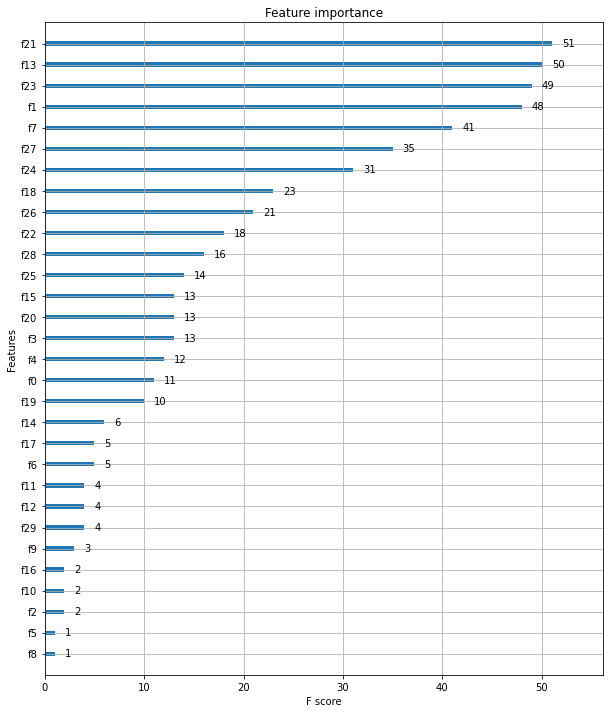

In [32]:
# XGBoost는 f1 스코어를 기반으로 피처 중요도 시각화 지원

from xgboost import plot_importance

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [ ]:
# 아래 피쳐들이 f1스코어를 기준으로 가장 중요한 상위 5가지 피처

In [56]:
cancer_df.columns[7]

'mean concave points'

In [55]:
cancer_df.columns[1]

'mean texture'

In [54]:
cancer_df.columns[23]

'worst area'

In [53]:
cancer_df.columns[13]

'area error'

In [52]:
cancer_df.columns[21]

'worst texture'

# 최적의 파라미터
---

In [59]:
# 최적 파라미터를 구할 수 있는 방법을 cv API로 제공

xgb.cv

<function xgboost.training.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)>